In [2]:
pip install pandas openpyxl



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('online_retail.xlsx')  # replace with your file path

# Convert to CSV
df.to_csv('online_retail.csv', index=False)  # index=False to remove row numbers


Total items: 541909 Unique: 4070
m=10000,k=3,FPR=0.3533,Sensitivity=True
m=10000,k=5,FPR=0.4985,Sensitivity=True
m=10000,k=7,FPR=0.6947,Sensitivity=True
m=50000,k=3,FPR=0.0152,Sensitivity=True
m=50000,k=5,FPR=0.0025,Sensitivity=True
m=50000,k=7,FPR=0.0023,Sensitivity=True
m=100000,k=3,FPR=0.0027,Sensitivity=True
m=100000,k=5,FPR=0.0013,Sensitivity=True
m=100000,k=7,FPR=0.0000,Sensitivity=True
Exact top20: [('85123A', 2313), ('22423', 2203), ('85099B', 2159), ('47566', 1727), ('20725', 1639)]
k=5, recovered=0, mean_error=973.00
k=10, recovered=0, mean_error=382.80
k=20, recovered=0, mean_error=441.75
k=50, recovered=4, mean_error=472.31


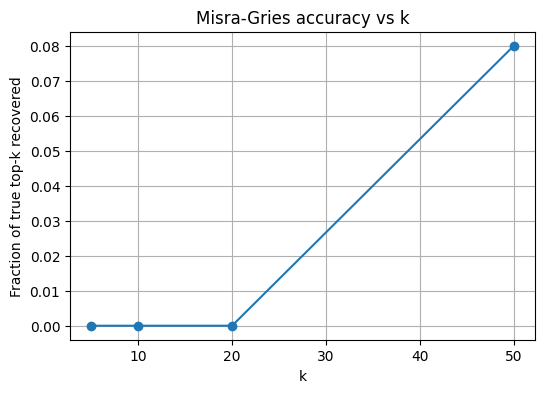

In [2]:
import pandas as pd, numpy as np, random, hashlib, matplotlib.pyplot as plt
from collections import Counter

# --- Load dataset
df = pd.read_csv("Online_Retail.csv", encoding='latin1')
df = df.dropna(subset=['StockCode'])
stockcodes = df['StockCode'].astype(str).tolist()
unique_codes = list(set(stockcodes))
print("Total items:", len(stockcodes), "Unique:", len(unique_codes))

# --- Bloom Filter class
class BloomFilter:
    def __init__(self, m, k):
        self.m = m; self.k = k
        self.bits = np.zeros(m, dtype=bool)
    def _hashes(self, item):
        h1 = int(hashlib.md5(item.encode()).hexdigest(),16)
        h2 = int(hashlib.sha1(item.encode()).hexdigest(),16)
        for i in range(self.k):
            yield (h1 + i*h2) % self.m
    def add(self,item):
        for h in self._hashes(item): self.bits[h]=True
    def __contains__(self,item):
        return all(self.bits[h] for h in self._hashes(item))

# --- Bloom Filter experiment
def bloom_experiment(unique_codes, m_values, k_values, x_values):
    results=[]
    for m in m_values:
        for k in k_values:
            bf = BloomFilter(m,k)
            for code in unique_codes:
                bf.add(code)
            sens = all((c in bf) for c in random.sample(unique_codes, min(1000,len(unique_codes))))
            fps=[]
            for x in x_values:
                false=0
                for _ in range(x):
                    fake="X"+str(random.randint(100000,999999))
                    if fake in bf: false+=1
                fps.append(false/x)
            results.append((m,k,fps))
            print(f"m={m},k={k},FPR={np.mean(fps):.4f},Sensitivity={sens}")
    return results

m_values=[10000,50000,100000]
k_values=[3,5,7]
x_values=[100,200,500,1000]
bloom_results=bloom_experiment(unique_codes,m_values,k_values,x_values)

# --- Misra–Gries
def misra_gries(stream,k):
    counters={}
    for item in stream:
        if item in counters: counters[item]+=1
        elif len(counters)<k: counters[item]=1
        else:
            for key in list(counters.keys()):
                counters[key]-=1
                if counters[key]==0: del counters[key]
    return counters

counts=Counter(stockcodes)
exact_top=counts.most_common(20)
print("Exact top20:", exact_top[:5])

k_values_mg=[5,10,20,50]
recov=[]; errors=[]
for k in k_values_mg:
    est=misra_gries(stockcodes,k)
    topk=[x for x,_ in counts.most_common(k)]
    est_top=list(est.keys())
    recovered=len(set(est_top)&set(topk))
    mean_err=np.mean([counts[i]-est.get(i,0) for i in est_top])
    recov.append(recovered/k)
    errors.append(mean_err)
    print(f"k={k}, recovered={recovered}, mean_error={mean_err:.2f}")

plt.figure(figsize=(6,4))
plt.plot(k_values_mg, recov, marker='o')
plt.xlabel('k'); plt.ylabel('Fraction of true top-k recovered')
plt.title('Misra-Gries accuracy vs k')
plt.grid(); plt.show()
